Project Description

The telecommunications operator wants to combat customer churn. To do this, their staff will start offering promo codes and special conditions to those who plan to discontinue their services. To proactively identify such users, "TeleDom" needs a model that will predict whether a subscriber will terminate their contract. The operator's team has gathered personal data about some clients, as well as information about their tariffs and services. Your task is to train a model on this data to predict customer churn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
!pip install phik
from phik import resources

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import seaborn as sns

RANDOM_STATE = 120824

     |████████████████████████████████| 686 kB 1.3 MB/s eta 0:00:01


In [2]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: 
            names = raw_col_name  
        
        if isinstance(names,np.ndarray):
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

## Data upload

The data consists of several files obtained from different sources:

contract_new.csv — contract information;

personal_new.csv — personal data of the client;

internet_new.csv — information about internet services;

phone_new.csv — information about telephony services.

In [3]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

### Contract_new

In [4]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges']

In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


We see that some clients started their contracts on the day the data was extracted, so they haven't been charged for services yet. In the future, it would be reasonable to fill these 'gaps' with zero values.

In [7]:
contract['total_charges'].value_counts()

           11
20.45       6
101.0       5
255.0       4
1007.5      4
           ..
192.5       1
4112.35     1
557.6       1
3089.99     1
20.24       1
Name: total_charges, Length: 6658, dtype: int64

In [8]:
contract[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Let's conduct a brief check: do we only know the dates of contracts that have already ended, or do we have information about customers who will terminate their contracts in the near future?

Answer: We only have information about contracts that have already been terminated.

In [9]:
end_date_known = pd.to_datetime(contract['end_date'][contract['end_date'] != 'No'])
print(f'years of contract ending: {end_date_known.dt.year.value_counts()}')
print(f'latest date of contract ending: {end_date_known.max()}')

years of contract ending: 2019    333
2018    285
2017    235
2016    140
2015     62
2020     39
2014      7
Name: end_date, dtype: int64
latest date of contract ending: 2020-01-01 00:00:00



During the initial data review, we will immediately change the data types where it makes sense:

Add a variable active_contract: This will store information on whether the client is terminating the contract — this will serve as the target variable for our prediction task.

Convert date columns to datetime format, filling missing EndDate values with a placeholder (e.g., a null or default value).

Convert TotalCharges to float64 format: We'll fill in zeros for cases where the contract has just started and no charges have been applied yet.

In [10]:
contract['active_contract'] = contract['end_date'] == 'No'
contract['begin_date'] = pd.to_datetime(contract['begin_date'])
contract['end_date'] = pd.to_datetime(contract['end_date'].replace({'No':'2020-02-01'}))
contract['total_charges'] = contract['total_charges'].replace({' ': 0}).astype('float64')

In [11]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   active_contract    7043 non-null   bool          
dtypes: bool(1), datetime64[ns](2), float64(2), object(4)
memory usage: 447.2+ KB


### Personal_new

In [12]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [13]:
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

In [14]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In this dataframe, there is no need to change the data formats. The only adjustment I would make is to verify that all CustomerID values match with the CustomerID in the contracts dataframe and change the data type of the senior_citizen column.

In [15]:
set(personal['customer_id']).symmetric_difference(set(contract['customer_id']))

set()

In [16]:
personal['senior_citizen'] = personal['senior_citizen'].astype('bool')

In [17]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   bool  
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: bool(1), object(4)
memory usage: 227.1+ KB


In [18]:
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,False,Yes,No
1,5575-GNVDE,Male,False,No,No
2,3668-QPYBK,Male,False,No,No
3,7795-CFOCW,Male,False,No,No
4,9237-HQITU,Female,False,No,No


### Internet_new

In [19]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [20]:
internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

In [21]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Data format in this df suits our task.

### Phone_new

In [22]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [23]:
phone.columns = ['customer_id', 'multiple_lines']

In [24]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Data format in this df suits our task.

Conclusion: Overall, the data is very user-friendly — there are no missing values, and the customer_id format is consistent across all dataframes. The only necessary adjustments at this stage were to change the format of certain data and rename columns for easier future processing.

## Data preprocessing and exploratory data analysis

### Contract_new

In [25]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,active_contract
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,True
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,True
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,True
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,True
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,True


In [26]:
numeric_columns = ['monthly_charges', 'total_charges']
cat_columns = ['type', 'paperless_billing', 'payment_method', 'active_contract']

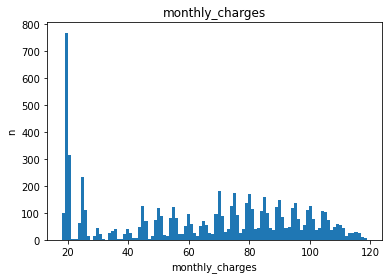

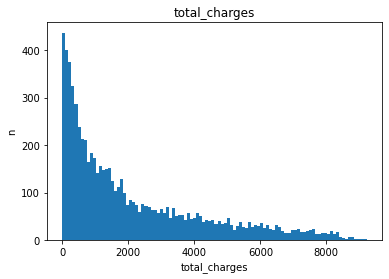

In [27]:
for i in numeric_columns:
    plt.hist(contract[i], bins=100)
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('n')
    plt.show()

We note the bimodality in the distribution of monthly payments (with a peak around 20 and a more gradual peak around 80). Additionally, there's a tendency for charges to be rounded (observations tend to cluster around multiples of tens and fives, with local peaks at 70, 75, and 80).

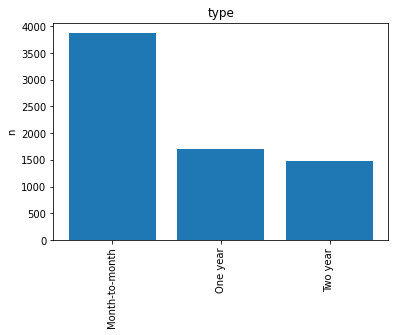

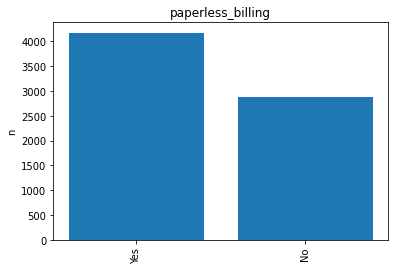

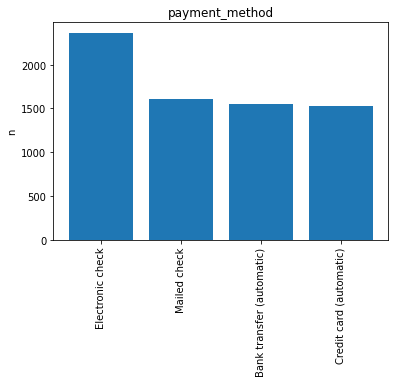

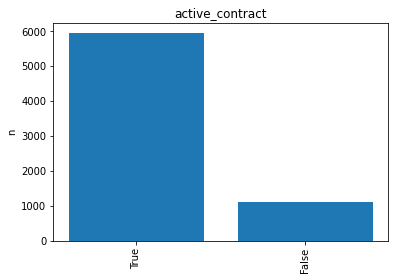

In [28]:
for i in cat_columns:
    plt.bar(range(len(contract[i].unique())), contract[i].value_counts())
    plt.title(i)
    plt.xticks(range(len(contract[i].unique())), contract[i].unique(), rotation=90)
    plt.ylabel('n')
    plt.show()

The only point worth noting here is the class imbalance in the task we are working on. This won’t be an issue, as the ROC AUC metric is not sensitive to class imbalance, so we will not augment the data.

I have a hypothesis: the peak at monthly_charge ~ 20 consists of clients who joined very early, around 2014-2015, and are still on old pricing plans. Let's test this hypothesis:

In [29]:
monthly_charge = pd.Series(contract['monthly_charges'])
monthly_charge.index = contract['begin_date']

perform a seasonal decomposition (using seasonal_decompose), averaging the tariffs by month

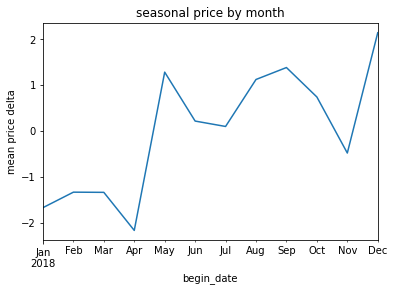

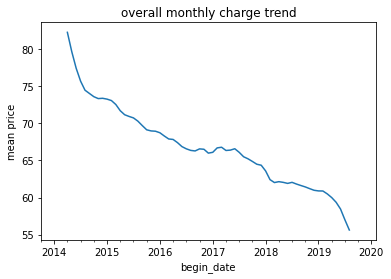

In [30]:
monthly_charge = monthly_charge.resample('1M').mean()
decomposed = seasonal_decompose(monthly_charge)

decomposed.seasonal['2018-01-01':'2019-01-01'].plot()
plt.title('seasonal price by month')
plt.ylabel('mean price delta')
plt.show()

decomposed.trend.plot()
plt.title('overall monthly charge trend')
plt.ylabel('mean price')
plt.show()

In [31]:
contract['n_years'] = contract['end_date'].dt.year - contract['begin_date'].dt.year
contract = contract[['customer_id', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'active_contract',
       'n_years']]

In [32]:
contract.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,active_contract,n_years
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,True,0
1,5575-GNVDE,One year,No,Mailed check,56.95,True,3
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,True,1
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,True,4
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,True,1


### Personal_new

In [33]:
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,False,Yes,No
1,5575-GNVDE,Male,False,No,No
2,3668-QPYBK,Male,False,No,No
3,7795-CFOCW,Male,False,No,No
4,9237-HQITU,Female,False,No,No


In [34]:
cat_columns = ['gender', 'senior_citizen', 'partner', 'dependents']

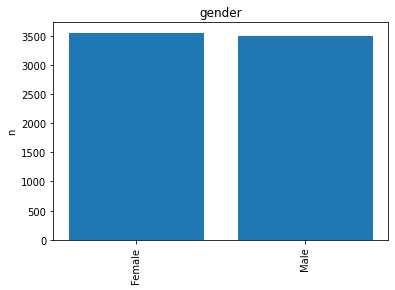

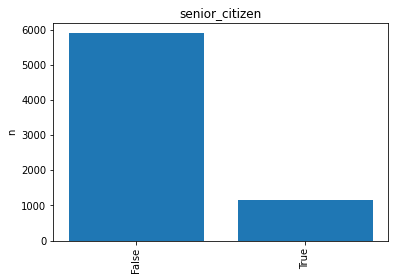

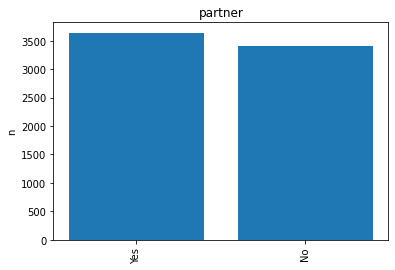

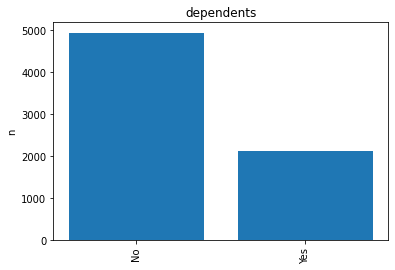

In [35]:
for i in cat_columns:
    plt.bar(range(len(personal[i].unique())), personal[i].value_counts())
    plt.title(i)
    plt.xticks(range(len(personal[i].unique())), personal[i].unique(), rotation=90)
    plt.ylabel('n')
    plt.show()

it makes sense to keep all the features from this df — for example, seniors tend to monitor their finances more carefully, while dependents are generally very demanding regarding the streaming services and movies available in the catalog.

In [36]:
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,False,Yes,No
1,5575-GNVDE,Male,False,No,No
2,3668-QPYBK,Male,False,No,No
3,7795-CFOCW,Male,False,No,No
4,9237-HQITU,Female,False,No,No


### Internet_new

In [37]:
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [38]:
cat_columns = ['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies']

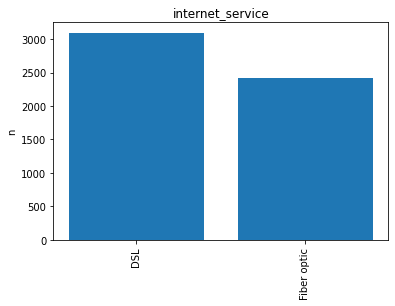

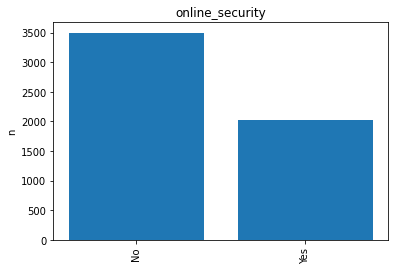

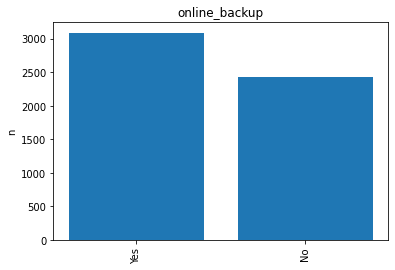

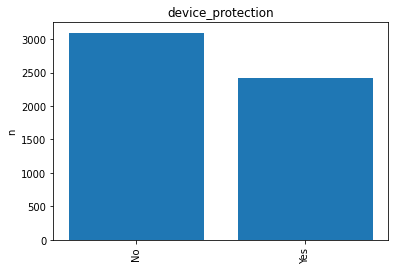

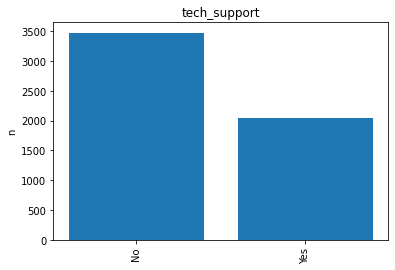

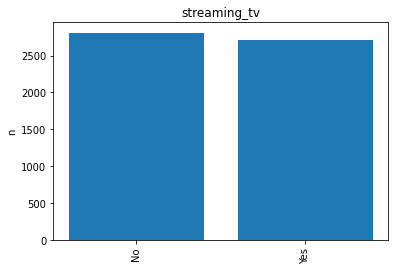

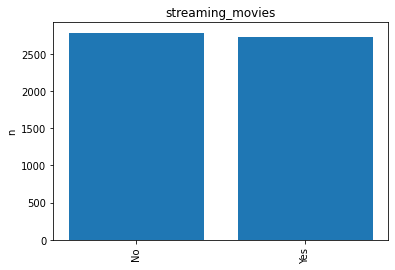

In [39]:
for i in cat_columns:
    plt.bar(range(len(internet[i].unique())), internet[i].value_counts())
    plt.title(i)
    plt.xticks(range(len(internet[i].unique())), internet[i].unique(), rotation=90)
    plt.ylabel('n')
    plt.show()

In this dataframe, I would keep all the features for further analysis—they all provide some value to the customer.

### Phone_new

In [40]:
phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [41]:
cat_columns = ['multiple_lines']

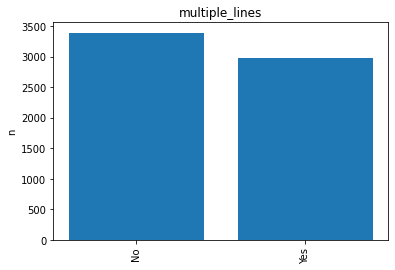

In [42]:
for i in cat_columns:
    plt.bar(range(len(phone[i].unique())), phone[i].value_counts())
    plt.title(i)
    plt.xticks(range(len(phone[i].unique())), phone[i].unique(), rotation=90)
    plt.ylabel('n')
    plt.show()

In this dataframe, I would keep all the features for further analysis—they all provide some value to the customer.

## Combining data

Let's combine all the data using an outer join to ensure we don't lose customers who only use phone services or only internet services.

In [43]:
contract.index = contract['customer_id']
contract=contract.drop(columns = 'customer_id')

personal.index = personal['customer_id']
personal=personal.drop(columns = 'customer_id')

internet.index = internet['customer_id']
internet=internet.drop(columns = 'customer_id')

phone.index = phone['customer_id']
phone=phone.drop(columns = 'customer_id')

total_df = pd.concat([contract, personal, internet, phone], axis=1, join='outer')

In [44]:
total_df.head()

,type,paperless_billing,payment_method,monthly_charges,active_contract,n_years,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,True,0,Female,False,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,One year,No,Mailed check,56.95,True,3,Male,False,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,True,1,Male,False,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,True,4,Male,False,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,True,1,Female,False,No,No,Fiber optic,No,No,No,No,No,No,No


Now we need to fill in the missing values for customers who do not use phone or internet services.

In [45]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   active_contract    7043 non-null   bool   
 5   n_years            7043 non-null   int64  
 6   gender             7043 non-null   object 
 7   senior_citizen     7043 non-null   bool   
 8   partner            7043 non-null   object 
 9   dependents         7043 non-null   object 
 10  internet_service   5517 non-null   object 
 11  online_security    5517 non-null   object 
 12  online_backup      5517 non-null   object 
 13  device_protection  5517 non-null   object 
 14  tech_support       5517 non-null   object 
 15  streaming_tv       5517 non-null   object 
 16  streaming_movi

In [46]:
total_df[internet.columns] = total_df[internet.columns].fillna('Not used')
total_df[phone.columns] = total_df[phone.columns].fillna('Not used')

In [47]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   active_contract    7043 non-null   bool   
 5   n_years            7043 non-null   int64  
 6   gender             7043 non-null   object 
 7   senior_citizen     7043 non-null   bool   
 8   partner            7043 non-null   object 
 9   dependents         7043 non-null   object 
 10  internet_service   7043 non-null   object 
 11  online_security    7043 non-null   object 
 12  online_backup      7043 non-null   object 
 13  device_protection  7043 non-null   object 
 14  tech_support       7043 non-null   object 
 15  streaming_tv       7043 non-null   object 
 16  streaming_movi

Let's check whether the features are correlated with each other.

In [48]:
interval_cols=['monthly_charges', 'n_years']

total_df.phik_matrix(interval_cols=interval_cols)

,type,paperless_billing,payment_method,monthly_charges,active_contract,n_years,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
type,1.000000,0.106860,0.277462,0.388266,0.094015,0.586767,0.000000,0.086231,0.179736,0.147680,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.244410
paperless_billing,0.106860,1.000000,0.370495,0.467783,0.083398,0.070136,0.000000,0.242133,0.013218,0.172593,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.099953
payment_method,0.277462,0.370495,1.000000,0.399536,0.214832,0.434303,0.000000,0.292725,0.243008,0.224903,0.323886,0.315799,0.293413,0.297923,0.317713,0.284531,0.285525,0.174849
monthly_charges,0.388266,0.467783,0.399536,1.000000,0.225925,0.285962,0.009025,0.304691,0.203237,0.184213,0.918980,0.812633,0.818858,0.827318,0.816603,0.864642,0.863641,0.710101
active_contract,0.094015,0.083398,0.214832,0.225925,1.000000,0.347844,0.008581,0.086159,0.226688,0.046871,0.056621,0.058659,0.089704,0.085608,0.051537,0.078545,0.086577,0.105101
n_years,0.586767,0.070136,0.434303,0.285962,0.347844,1.000000,0.028405,0.072704,0.425870,0.186889,0.111387,0.323101,0.341569,0.347090,0.330178,0.285367,0.282782,0.306823
gender,0.000000,0.000000,0.000000,0.009025,0.008581,0.028405,1.000000,0.000000,0.000000,0.000000,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.086231,0.242133,0.292725,0.304691,0.086159,0.072704,0.000000,1.000000,0.016992,0.324576,0.160702,0.127319,0.109995,0.110177,0.135283,0.111714,0.113778,0.087925
partner,0.179736,0.013218,0.243008,0.203237,0.226688,0.425870,0.000000,0.016992,1.000000,0.652122,0.000000,0.091202,0.092012,0.100092,0.076326,0.082251,0.077506,0.086249
dependents,0.147680,0.172593,0.224903,0.184213,0.046871,0.186889,0.000000,0.324576,0.652122,1.000000,0.108463,0.117219,0.097766,0.094597,0.109753,0.088193,0.084684,0.011198


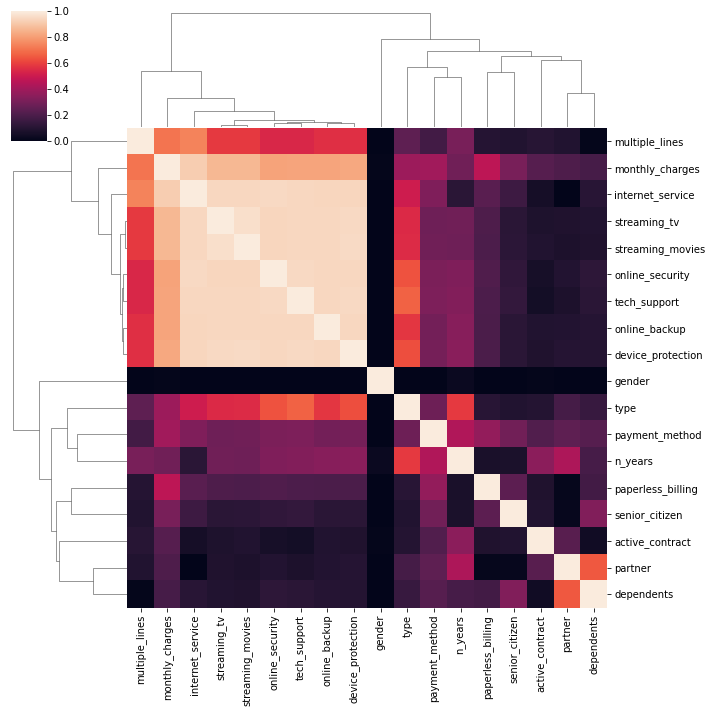

In [49]:
sns.clustermap(total_df.phik_matrix(interval_cols=interval_cols))

The only strongly correlated variables are monthly_charges and the variables describing various internet services (it's obvious that internet fees are much higher than phone fees). We'll get rid of them.

In [50]:
total_df = total_df.drop(['internet_service', 'online_backup', 'device_protection', 'tech_support', 
                         'streaming_tv', 'online_security'], axis=1)

In [51]:
total_df.phik_matrix(interval_cols=interval_cols)

,type,paperless_billing,payment_method,monthly_charges,active_contract,n_years,gender,senior_citizen,partner,dependents,streaming_movies,multiple_lines
type,1.000000,0.106860,0.277462,0.388266,0.094015,0.586767,0.000000,0.086231,0.179736,0.147680,0.553556,0.244410
paperless_billing,0.106860,1.000000,0.370495,0.467783,0.083398,0.070136,0.000000,0.242133,0.013218,0.172593,0.202241,0.099953
payment_method,0.277462,0.370495,1.000000,0.399536,0.214832,0.434303,0.000000,0.292725,0.243008,0.224903,0.285525,0.174849
monthly_charges,0.388266,0.467783,0.399536,1.000000,0.225925,0.285962,0.009025,0.304691,0.203237,0.184213,0.863641,0.710101
active_contract,0.094015,0.083398,0.214832,0.225925,1.000000,0.347844,0.008581,0.086159,0.226688,0.046871,0.086577,0.105101
n_years,0.586767,0.070136,0.434303,0.285962,0.347844,1.000000,0.028405,0.072704,0.425870,0.186889,0.282782,0.306823
gender,0.000000,0.000000,0.000000,0.009025,0.008581,0.028405,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.086231,0.242133,0.292725,0.304691,0.086159,0.072704,0.000000,1.000000,0.016992,0.324576,0.113778,0.087925
partner,0.179736,0.013218,0.243008,0.203237,0.226688,0.425870,0.000000,0.016992,1.000000,0.652122,0.077506,0.086249
dependents,0.147680,0.172593,0.224903,0.184213,0.046871,0.186889,0.000000,0.324576,0.652122,1.000000,0.084684,0.011198


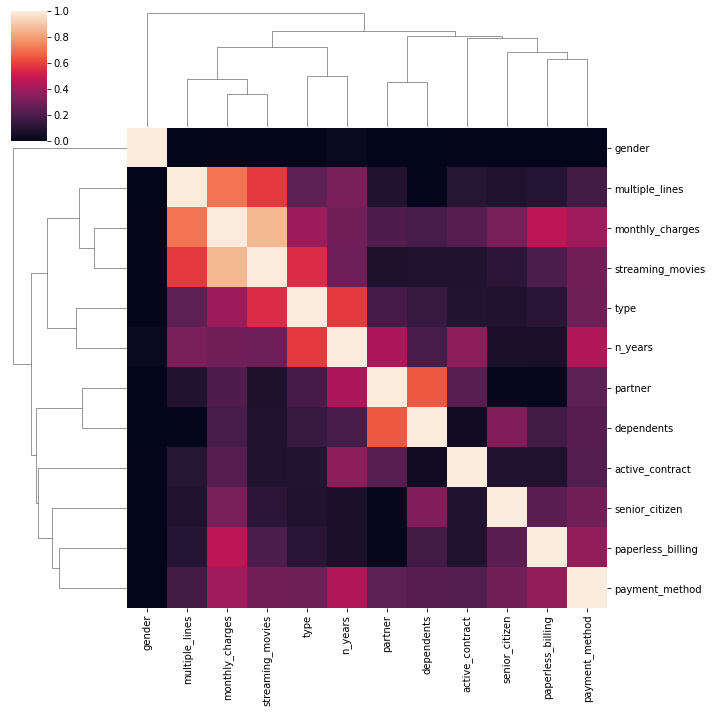

In [52]:
sns.clustermap(total_df.phik_matrix(interval_cols=interval_cols))

## Data preparation

### Train-test split

In [53]:
train, test = train_test_split(total_df, test_size = .25, stratify=total_df['active_contract'], 
                              random_state=RANDOM_STATE)

In [54]:
y_train = train['active_contract']
X_train = train.drop('active_contract', axis=1)

y_test = test['active_contract']
X_test = test.drop('active_contract', axis=1)

### Transformers

In [55]:
categorical_features = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'dependents', 'partner', 'gender']
categorical_features_service_specific = ['streaming_movies', 'multiple_lines']
numerical_features = ['monthly_charges', 'n_years'] 

In [56]:
numerical_transformer = Pipeline([
    ('scaler', MaxAbsScaler()),
])


categorical_transformer = categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))
])

categorical_service_specific_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop=['Not used']*len(categorical_features_service_specific), handle_unknown='error'))
])

In [57]:
preprocessor_for_classifier = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features), 
    ('cat_ss', categorical_service_specific_transformer, categorical_features_service_specific),
], remainder='passthrough')

In [58]:
train_transformed = preprocessor_for_classifier.fit_transform(X_train)
X_train_transformed = pd.DataFrame(train_transformed, 
                                   columns = get_column_names_from_ColumnTransformer(preprocessor_for_classifier))

test_transformed = preprocessor_for_classifier.transform(X_test)
X_test_transformed = pd.DataFrame(test_transformed, 
                                   columns = get_column_names_from_ColumnTransformer(preprocessor_for_classifier))

In [59]:
X_train_transformed.head()

,monthly_charges,n_years,x0_One year,x0_Two year,x1_Yes,x2_Credit card (automatic),x2_Electronic check,x2_Mailed check,x3_True,x4_Yes,x5_Yes,x6_Male,x0_No,x0_Yes,x1_No,x1_Yes
0,0.798737,0.142857,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.626105,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.245474,0.142857,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.587368,0.142857,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.807158,0.142857,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


I beautified the names of the encoded features to make the further analysis of the features more visually appealing 

In [60]:
X_train_transformed.columns = X_test_transformed.columns = ['monthly_charges', 'n_years', 'type_one_year',
'type_two_year',
'payment_paperless_billing',
'payment_method_credit_card',
'payment_method_electronic_check',
'payment_method_mailed_check',
'is_senior',
'dependents',
'partner',
'gender_male',
'streaming_movies_no',
'streaming_movies_yes',
'multiple_lines_no',
'multiple_lines_yes']

In [61]:
X_train_transformed.head()

,monthly_charges,n_years,type_one_year,type_two_year,payment_paperless_billing,payment_method_credit_card,payment_method_electronic_check,payment_method_mailed_check,is_senior,dependents,partner,gender_male,streaming_movies_no,streaming_movies_yes,multiple_lines_no,multiple_lines_yes
0,0.798737,0.142857,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.626105,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.245474,0.142857,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.587368,0.142857,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.807158,0.142857,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


## Model training

### Random forest

In [62]:
param_dist = {
    'n_estimators': np.arange(150, 400, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [9, 10, 11], 
    'bootstrap': [True, False]
}


rf = RandomForestClassifier(random_state=RANDOM_STATE)


rf_random = RandomizedSearchCV(estimator=rf,
                               scoring='roc_auc',
                               param_distributions=param_dist,
                               n_iter=10,
                               cv=5, 
                               verbose=0,
                               random_state=RANDOM_STATE,
                               n_jobs=-1)


rf_random.fit(X_train_transformed, y_train)


print(f"Best Parameters: {rf_random.best_params_}")
print(f"Best Score: {rf_random.best_score_}")

Best Parameters: {'n_estimators': 380, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'auto', 'bootstrap': False}
Best Score: 0.8458175317632088


### CatBoost

In [63]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [40 , 50, 100, 300, 500],
    'depth': [2, 4]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

cb_grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
cb_grid.fit(X_train_transformed, y_train)

print(f"Best Parameters: {cb_grid.best_params_}")
print(f"Best Score: {cb_grid.best_score_}")

Best Parameters: {'depth': 4, 'learning_rate': 0.2, 'n_estimators': 50}
Best Score: 0.8567662385261249


## Best performance model analysis

In our case, this is a CatBoostClassifier with the parameters {'depth': 4, 'learning_rate': 0.2, 'n_estimators': 50}.

In [64]:
y_pred = cb_grid.best_estimator_.predict_proba(X_test_transformed)[:, 1]
roc_auc_score(y_test, y_pred)

0.8557163832130184

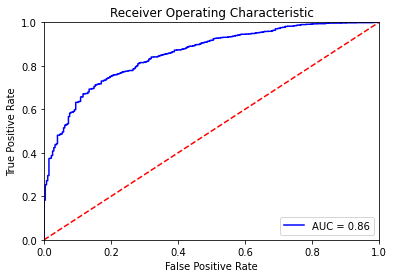

In [65]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

accuracy calculation:

In [66]:
y_pred_classes = pd.Series(y_pred > .5, index=X_test.index)
print(f"CatBoost accuracy score on test set: {accuracy_score(y_test, y_pred_classes.astype(bool))}")

CatBoost accuracy score on test set: 0.8705281090289608


feature importance estimation:

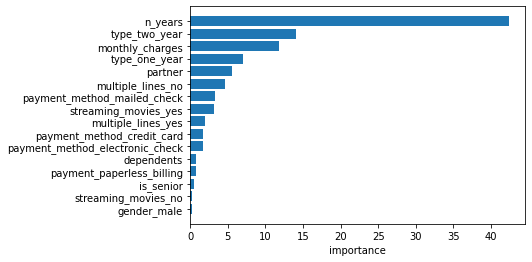

In [67]:
importances = cb_grid.best_estimator_.feature_importances_
labels = cb_grid.best_estimator_.feature_names_
importances = pd.Series(importances, index=labels)

importances = importances.sort_values()

plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), importances.index)
plt.xlabel('importance')
plt.show()

So, we see that the most significant factor influencing a customer's decision to terminate their contract is the number of years spent with the provider (which makes sense considering the trends observed during the initial data analysis). Additionally, the monthly fee and the payment type affect the customer's decision (if a customer pays annually or biannually, they are more likely to discontinue the services).

In [69]:
pd.DataFrame(confusion_matrix(y_test, y_pred_classes), columns=['observed_left', 'observed_stayed'], 
            index = ['predicted_left', 'predicted_stayed'])

,observed_left,observed_stayed
predicted_left,73,202
predicted_stayed,26,1460


The analysis of the confusion matrix shows that the tested model accurately predicts most of the "stayed" class (contract not terminated). However, the prediction for the "left" class (contract terminated) is significantly worse, with only 3/4 of the values correctly predicted. This means that the model will effectively predict a user who does not intend to terminate their contract, but it will only predict whether a user will terminate the contract with 75% accuracy.

## Conclusion and customer recomendations

To complete the project, the following steps were taken:

The initial data was analyzed. A new feature was created based on existing ones (the number of years the subscriber has been with the provider), while redundant features and those lacking relevance to the task (contract start and end years, detailed descriptions of services provided, total charges paid by the client throughout the contract) were removed.

Two models were built using gradient boosting, and hyperparameters were tuned for each model using randomized search and grid search. The best model was selected based on the ROC AUC score (CatBoostClassifier with parameters {'depth': 4, 'learning_rate': 0.2, 'n_estimators': 50}).

The best model was validated on a validation set, achieving a ROC AUC metric exceeding the required threshold of 0.85.

An analysis was conducted on the features important for predicting contract termination by clients. Based on this analysis, the following recommendations can be made to the client:

a) Review tariffs for loyal customers— the longer a client uses the provider's services, the more apparent it becomes that tariffs are increasingly advantageous, leading to potential overpayment for the same service package.

b) Whenever possible, switch clients to monthly payments— even if tariffs for loyal clients are not revised, overpayment in monthly billing is less apparent compared to annual payments.

c) If a client uses telephone services, the absence of multiple phone lines significantly influences their decision to change providers— offering the option to add lines could be beneficial.